# Quantum bounds for a parametric Bell expression

Consider a setting where nparties share a global state $\ket{\psi}$ on which they may perform mdifferent local measurements with $k$ possible outcomes. This experiment is described by the conditional probability distribution 

$$P= P(a_1, \dots, a_n| x_1, \dots, x_n)$$

of observing the outcomes $a_i = 1, \dots, $ given the possible measurement settings $x_i = 1, \dots, m$. A Bell expression $\beta$ in this scenario is a linear map that associates a Bell score

$$\vec{\beta} \cdot \vec{P} \equiv \beta(P) = \sum_{a, x} \alpha_{a|x} P(a|x)$$

to every probability distribution $P$. Here, $\alpha_{a|x}$ are the Bell expression’s coefficients and $a =
(a_1, \dots, a_n)$, $x = (x_1, \dots, x_n)$ are vectors containing the outcomes and setting choices of all parties.

Given a choice of measurement projectors $\{\hat{\Pi}^{(i)}_{a|x}\}$, with $\hat{\Pi}^{(i)}_{a|x} \in \mathcal{L}(\mathcal{H}^{(i)})$ and $\sum_a \hat{\Pi}^{(i)}_{a|x} = 1$, a Bell expression $\beta$ gives rise to a Bell operator

$$\hat{S} = \sum_{a,x} \alpha_{a|x} $$

which acts on the full Hilbert space $\mathcal{H} = \mathcal{H}^{(1)} \otimes \dots \otimes \mathcal{H}^{(n)}$: $\hat{S} \in \mathcal{L}(\mathcal{H})$. In the case of binary outcomes ($k = 2$), the measurements can also be described in terms of measurement operators:

$$\hat{M}^{(i)}_x \equiv \hat{\Pi}^{(i)}_{1|x} - \hat{\Pi}_{2|x}^{(i)}$$

with eigenvalue $\pm 1$ for each party. 

## Tsirelson point Bell expression

We are considering the Bell expression

$$\beta_{r_0, r_1} = r_0 \left(\frac{A_0 + A_1}{\sqrt{2}} - B_0 \right) + r_1 \left(\frac{A_0 - A_1}{\sqrt{2}} - B_1 \right) + \frac{1}{2\sqrt{2}} \left((A_0 + A_1)B_0 + (A_0 - A_1)B_1 \right) $$

and we want to find a bound for the Bell expression for every choice of $(r_0, r_1)$.

We start by importing the following libraries

In [1]:
import numpy as np
import ncpol2sdpa as ncp
from ncpol2sdpa import *
import matplotlib.pyplot as plt

We define the settings and the operators

In [2]:
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

We define functions for adding extra monomials to the relaxation:

In [3]:
def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    # ABB
    for a in Aflat:
        for b in Bflat:
            for b2 in Bflat:
                monos += [a*b*b2]
    # AAB
    for a in Aflat:
        for a2 in Aflat:
            for b in Bflat:
                monos += [a*a2*b]

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

We are now ready to perform the relaxation and get the Tsirelson bound! But first, we have to change notation. Since 

$$\hat{\Pi}_{a|x}^{(i=0)} = \hat{A}_{a|x}, \quad \hat{\Pi}_{b|y}^{(i=1)} = \hat{B}_{b|y},$$

we have

$$\hat{A}_x = 2 \hat{A}_{0|x} - 1, \qquad \hat{B}_y = 2 \hat{B}_{0|y} - 1.$$

In this notation, expanding, the Bell expression reads:

In [7]:
substitutions = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()    # extra monomials
LEVEL = 1

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

r0 = -0.5
r1 = 0.5

s = np.sqrt(2)

obj = 1./s - s*A[0][0] - s*B[0][0] + s*A[0][0]*B[0][0] + s*A[1][0]*B[0][0] + s*A[0][0]*B[1][0] - s*A[1][0]*B[1][0] + r0 - s*r0 + s*A[0][0]*r0 + s*A[1][0]*r0 - 2*B[0][0]*r0 + r1 + s*A[0][0]*r1 - s*A[1][0]*r1 - 2*B[1][0]*r1

sdp = ncp.SdpRelaxation(ops, verbose = 1, normalized=True, parallel=0)
sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
sdp.solve('mosek')
print(-sdp.dual)

The problem has 4 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 152
Generating moment matrix...
Reduced number of SDP variables: 40 40 (done: 100.66%, ETA 00:00:-0.0)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 40              
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries    

We could try to create a grid in the $(r_0, r_1)$ plane and determine the quantum bound for every pixel of the grid!

In [14]:
import sys
import io

# Suppress output
stdout_backup = sys.stdout  # Backup original stdout
sys.stdout = io.StringIO()  # Redirect stdout to null

# Define a grid in the (r0, r1) plane
r0_vals = np.linspace(-0.5, 0.5, 100)  # Adjust resolution as needed
r1_vals = np.linspace(-0.5, 0.5, 100)

#level = 2  # Increase for better precision

# Store results
quantum_bounds = np.zeros((len(r0_vals), len(r1_vals)))

# Loop over (r0, r1) values
for i, r0 in enumerate(r0_vals):
    for j, r1 in enumerate(r1_vals):

        obj = 1./s - s*A[0][0] - s*B[0][0] + s*A[0][0]*B[0][0] + s*A[1][0]*B[0][0] + s*A[0][0]*B[1][0] - s*A[1][0]*B[1][0] + r0 - s*r0 + s*A[0][0]*r0 + s*A[1][0]*r0 - 2*B[0][0]*r0 + r1 + s*A[0][0]*r1 - s*A[1][0]*r1 - 2*B[1][0]*r1


        sdp = ncp.SdpRelaxation(ops, verbose = 1, normalized=True, parallel=0)
        sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
        sdp.solve('mosek')
        print(-sdp.dual)

        # Store the quantum bound at this (r0, r1)
        quantum_bounds[i, j] = -sdp.dual

# Restore original stdout
sys.stdout = stdout_backup

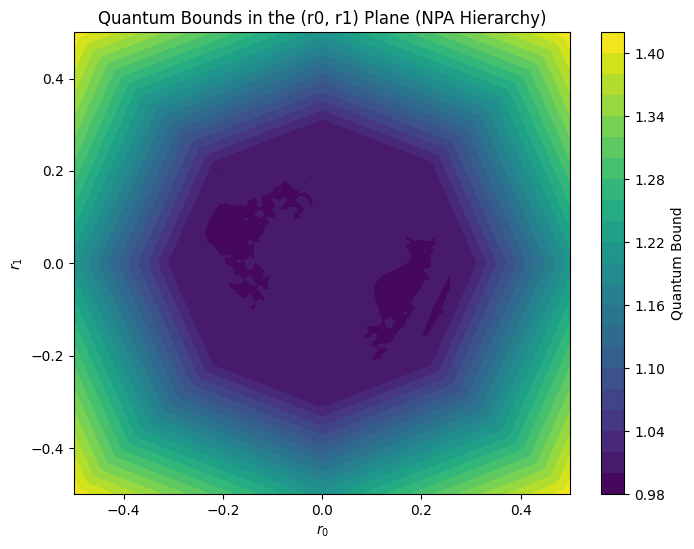

In [15]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(r0_vals, r1_vals, quantum_bounds, levels=20, cmap="viridis")
plt.colorbar(label="Quantum Bound")
plt.xlabel("$r_0$")
plt.ylabel("$r_1$")
plt.title("Quantum Bounds in the (r0, r1) Plane (NPA Hierarchy)")
plt.show()

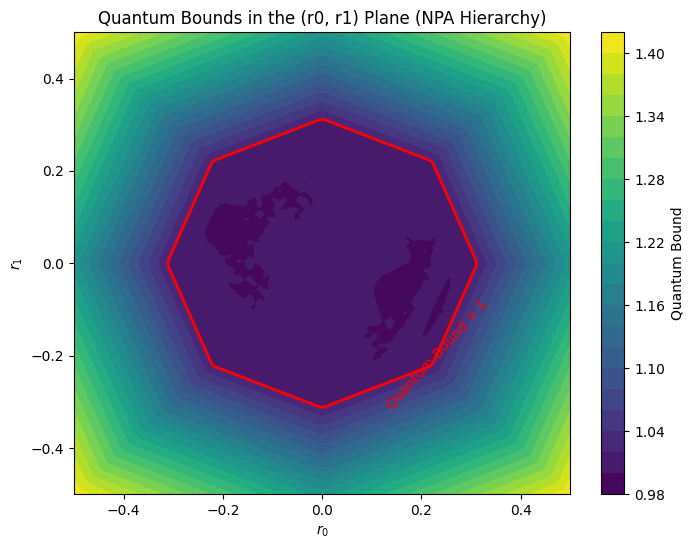

In [25]:
# Example plotting code with the additional contour line at quantum bound = 1
plt.figure(figsize=(8, 6))
contour = plt.contourf(r0_vals, r1_vals, quantum_bounds, levels=20, cmap="viridis")
plt.colorbar(label="Quantum Bound")

# Add a contour line for the quantum bound = 1
contour_line = plt.contour(r0_vals, r1_vals, quantum_bounds, levels=[1.02], colors='red', linewidths=2)
plt.clabel(contour_line, fmt="Quantum Bound = 1", inline=False, fontsize=10)

plt.xlabel("$r_0$")
plt.ylabel("$r_1$")
plt.title("Quantum Bounds in the (r0, r1) Plane (NPA Hierarchy)")
plt.show()

The NPA hierarchy conditions are asymptotically complete, but at this level they provide a necessary but not sufficient condition for the dual of the quantum set. But in this case, since at this level of the hierarchy, we have saturated the dual local bounds, which are contained in the dual quantum bounds, they provide a complete description of the dual quantum set for the Tsirelson point!